In [90]:
from pathlib import Path

import numpy as np 
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import cv2

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, Callback, ModelCheckpoint, CSVLogger
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input 
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.optimizers import Adam

from timeit import default_timer as timer

import itertools

### Chargement des données

In [91]:
df = pd.read_csv(Path("V2_Plant_Seedlings_DataFrame.csv"))
df.head()

,filepath,species,image_name,height,width,R_mean,G_mean,B_mean,luminosity,sharpness_score,image_size,square
0,Input\Maize\196.png,Maize,196.png,1260,1260,96.623133,95.263001,68.305443,86.730526,371.683979,1587600,square
1,Input\Cleavers\33.png,Cleavers,33.png,352,352,80.315397,70.118769,50.518635,66.984267,39.836262,123904,square
2,Input\Charlock\454.png,Charlock,454.png,990,990,80.529463,75.808330,55.868748,70.735514,305.574312,980100,square
3,Input\Small-flowered Cranesbill\5.png,Small-flowered Cranesbill,5.png,162,162,80.199131,71.348765,45.413733,65.653876,9.546821,26244,square
4,Input\Small-flowered Cranesbill\91.png,Small-flowered Cranesbill,91.png,323,323,83.221012,71.454773,45.279941,66.651909,31.808805,104329,square


### Séparation des jeux d'entraînement et de test

In [92]:
# Train/test split: 80% dans le jeu train, 20% dans le jeu test
train_df,test_df = train_test_split(df,
                                    test_size=0.2,
                                    random_state=3,
                                    shuffle=True,
                                    stratify=df['species'])


### Pre-processing

In [93]:
# Définition de la fonction de pre-processing incluant une étape de segmentation par seuillage

def mnv2_preprocessing_with_tsegm(threshold):
    def _mnv2_preprocessing_with_tsegm(input_img):
        # Etape 1: Segmentation simple par seuillage
        img_rgb = np.uint8(input_img)
        img_lab = cv2.cvtColor(img_rgb,cv2.COLOR_BGR2LAB)
        img_lab = cv2.resize(img_lab,(224,224))
         # Création du masque par seuillage
        _,mask = cv2.threshold(img_lab[:,:,1],threshold,255,cv2.THRESH_BINARY_INV)
         # Elimination du bruit par ouverture puis fermeture
        kernel = np.ones((2,2))
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
         # Application du masque à l'image
        masked_img = cv2.bitwise_and(img_rgb,img_rgb,mask=mask)

        # Etape 2: Pre-processing propre à MobileNetV2
        final_input = preprocess_input(masked_img)
        return final_input    
    return _mnv2_preprocessing_with_tsegm
    

In [94]:
# Paramètres de pre-processing

preprocessing_function = mnv2_preprocessing_with_tsegm(threshold=118)
color_mode = 'rgb'
target_size = (224,224)
channels = 3
batch_size = 32

In [95]:
# Instanciation du générateur de données 

# Générateur des données d'entraînement: avec augmentation "faible" des données
train_data_generator = ImageDataGenerator(preprocessing_function=preprocessing_function,
                                          rotation_range=90,
                                          width_shift_range=0.05, 
                                          height_shift_range=0.05,
                                          horizontal_flip=True,
                                          vertical_flip=True,
                                          validation_split=0.2)  # 20% du jeu train réservés pour évaluer le modèle au cours de l'entraînement

# Générateur des données de test: sans augmentation de données
test_data_generator = ImageDataGenerator(preprocessing_function=preprocessing_function)


In [96]:
# Instanciation des itérateurs associés aux trois jeux train, validation et test

train_iterator = train_data_generator.flow_from_dataframe(train_df,
                                                           x_col='filepath',
                                                           y_col='species',
                                                           target_size=target_size,
                                                           color_mode=color_mode,
                                                           class_mode='sparse',
                                                           batch_size=batch_size,
                                                           subset="training")
validation_iterator = train_data_generator.flow_from_dataframe(train_df,
                                                               x_col='filepath',
                                                               y_col='species',
                                                               target_size=target_size,
                                                               color_mode=color_mode,
                                                               class_mode='sparse',
                                                               batch_size=batch_size,
                                                               subset="validation")

test_iterator = test_data_generator.flow_from_dataframe(test_df,
                                                         x_col='filepath',
                                                         y_col='species',
                                                         target_size=target_size,
                                                         color_mode=color_mode,
                                                         class_mode='sparse',
                                                         batch_size=batch_size,
                                                         shuffle=False)


Found 3545 validated image filenames belonging to 12 classes.
Found 886 validated image filenames belonging to 12 classes.
Found 1108 validated image filenames belonging to 12 classes.


In [57]:
# Dictionnaire permettant de retrouver les classes à partir des labels
label2class = {x : y for y, x in train_iterator.class_indices.items()}
label2class

{0: 'Black-grass',
 1: 'Charlock',
 2: 'Cleavers',
 3: 'Common Chickweed',
 4: 'Common wheat',
 5: 'Fat Hen',
 6: 'Loose Silky-bent',
 7: 'Maize',
 8: 'Scentless Mayweed',
 9: "Shepherd's Purse",
 10: 'Small-flowered Cranesbill',
 11: 'Sugar beet'}

### Construction du modèle, définition des callbacks

In [97]:
# Transfer learning sur la base du modèle MobileNetV2

# Chargement du modèle de base MobileNetV2 pré-entraîné sur la base de données ImageNet
base_model = MobileNetV2(include_top = False,  # On conserve uniquement la partie convolutionnelle du modèle de base
                         input_shape=(target_size[0],target_size[1],channels),
                         weights = 'imagenet',
                         pooling='avg')
base_model.summary()
 

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

 block_3_expand_relu (ReLU)     (None, 56, 56, 144)  0           ['block_3_expand_BN[0][0]']      
                                                                                                  
 block_3_pad (ZeroPadding2D)    (None, 57, 57, 144)  0           ['block_3_expand_relu[0][0]']    
                                                                                                  
 block_3_depthwise (DepthwiseCo  (None, 28, 28, 144)  1296       ['block_3_pad[0][0]']            
 nv2D)                                                                                            
                                                                                                  
 block_3_depthwise_BN (BatchNor  (None, 28, 28, 144)  576        ['block_3_depthwise[0][0]']      
 malization)                                                                                      
                                                                                                  
 block_3_d

 lization)                                                                                        
                                                                                                  
 block_7_expand (Conv2D)        (None, 14, 14, 384)  24576       ['block_6_project_BN[0][0]']     
                                                                                                  
 block_7_expand_BN (BatchNormal  (None, 14, 14, 384)  1536       ['block_7_expand[0][0]']         
 ization)                                                                                         
                                                                                                  
 block_7_expand_relu (ReLU)     (None, 14, 14, 384)  0           ['block_7_expand_BN[0][0]']      
                                                                                                  
 block_7_depthwise (DepthwiseCo  (None, 14, 14, 384)  3456       ['block_7_expand_relu[0][0]']    
 nv2D)    

                                                                                                  
 block_10_depthwise_relu (ReLU)  (None, 14, 14, 384)  0          ['block_10_depthwise_BN[0][0]']  
                                                                                                  
 block_10_project (Conv2D)      (None, 14, 14, 96)   36864       ['block_10_depthwise_relu[0][0]']
                                                                                                  
 block_10_project_BN (BatchNorm  (None, 14, 14, 96)  384         ['block_10_project[0][0]']       
 alization)                                                                                       
                                                                                                  
 block_11_expand (Conv2D)       (None, 14, 14, 576)  55296       ['block_10_project_BN[0][0]']    
                                                                                                  
 block_11_

 block_14_depthwise (DepthwiseC  (None, 7, 7, 960)   8640        ['block_14_expand_relu[0][0]']   
 onv2D)                                                                                           
                                                                                                  
 block_14_depthwise_BN (BatchNo  (None, 7, 7, 960)   3840        ['block_14_depthwise[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 block_14_depthwise_relu (ReLU)  (None, 7, 7, 960)   0           ['block_14_depthwise_BN[0][0]']  
                                                                                                  
 block_14_project (Conv2D)      (None, 7, 7, 160)    153600      ['block_14_depthwise_relu[0][0]']
                                                                                                  
 block_14_

In [98]:
# Création du modèle complet: construction fonctionnelle

inputs = Input(shape=(target_size[0],target_size[1],channels),name='Input')
          
# Définition des couches de classification
classif_layer1 = Dropout(rate=0.2,name='Dropout_layer_1')
classif_layer2 = Dense(units=256,activation='relu',name='Dense_layer_1')
classif_layer3 = Dropout(rate=0.2,name='Dropout_layer_2')
classif_layer4 = Dense(units=128,activation='relu',name='Dense_layer_2')
classif_layer5 = Dropout(rate=0.2,name='Dropout_layer_3')
output_layer = Dense(units=12,activation='softmax',name='Dense_layer_output')

# Assemblage du modèle
x = base_model(inputs)
x = classif_layer1(x)
x = classif_layer2(x)
x = classif_layer3(x)
x = classif_layer4(x)
x = classif_layer5(x)
outputs = output_layer(x)

model = Model(inputs = inputs, outputs = outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 Dropout_layer_1 (Dropout)   (None, 1280)              0         
                                                                 
 Dense_layer_1 (Dense)       (None, 256)               327936    
                                                                 
 Dropout_layer_2 (Dropout)   (None, 256)               0         
                                                                 
 Dense_layer_2 (Dense)       (None, 128)               32896     
                                                           

In [59]:
# Définition des callbacks

reduce_learning_rate = ReduceLROnPlateau(monitor='val_accuracy',
                                         factor=0.5,
                                         min_delta=0.01,
                                         mode='max',
                                         patience=3,
                                         verbose=1)


# Callback mesurant la durée de l'entraînement 
class TimingCallback(Callback):
    def __init__(self, logs={}):
        self.logs=[]
    def on_train_begin(self, logs={}):
        self.starttime = timer()
    def on_train_end(self, logs={}):
        self.logs.append(timer()-self.starttime)

time_callback = TimingCallback()

In [12]:
# Fonction permettant de charger un éventuel modèle précédemment entraîné, de compiler et de lancer l'entraînement

def model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=None,lr=1.e-3,nb_epochs=30):
    
    # Chargement des poids obtenus lors d'un précédent entraînement
    if loadweights_filepath != None:
        print("Loading model weights")
        model.load_weights(loadweights_filepath)
        
    # Compilation
    print("Compiling model")
    model.compile(optimizer=Adam(learning_rate=lr),loss='sparse_categorical_crossentropy',metrics='accuracy')
    model.optimizer.lr.assign(lr)    # Assignation forcée pour éviter l'utilisation du LR chargé avec les poids (bug Keras?)
    print("Model compilation OK, learning rate =",model.optimizer.lr.numpy())
    
    # Définition du ModelCheckPoint
    model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                       monitor='val_accuracy',
                                       mode='max',
                                       save_best_only = True,
                                       save_weights_only = True,
                                       verbose=1)
    
    # Définition du CSV Logger (enregistrement de l'historique d'entraînement)
    csv_logger = CSVLogger(csvlogger_filepath,append=True)
    
    # Entraînement
    print("Launching training")
    training_history = model.fit(train_iterator,validation_data=validation_iterator,
                                 epochs=nb_epochs,
                                 steps_per_epoch=train_iterator.samples//batch_size,
                                 validation_steps=validation_iterator.samples//batch_size,
                                 callbacks=[time_callback,reduce_learning_rate,model_checkpoint,csv_logger],
                                 verbose=True)


### Entraînement du modèle

#### Etape 1: Entraînement avec les poids du modèle de base freezés

In [ ]:
# Freeze des poids du modèle de base
for layer in base_model.layers:
    layer.trainable = False  

In [15]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('Freeze','best_weights.ckpt')
csvlogger_filepath = Path('Freeze','training_history.csv')

In [113]:
# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath)

Epoch 1/30
110/110 [==============================] - ETA: 0s - loss: 1.1829 - accuracy: 0.5975
Epoch 1: val_accuracy improved from -inf to 0.83102, saving model to Models_training\MobileNetV2_ThresholdSegmentation\Freeze\best_weights.ckpt
110/110 [==============================] - 102s 903ms/step - loss: 1.1829 - accuracy: 0.5975 - val_loss: 0.4972 - val_accuracy: 0.8310 - lr: 0.0010
Epoch 2/30
110/110 [==============================] - ETA: 0s - loss: 0.6427 - accuracy: 0.7714
Epoch 2: val_accuracy improved from 0.83102 to 0.86574, saving model to Models_training\MobileNetV2_ThresholdSegmentation\Freeze\best_weights.ckpt
110/110 [==============================] - 106s 967ms/step - loss: 0.6427 - accuracy: 0.7714 - val_loss: 0.3747 - val_accuracy: 0.8657 - lr: 0.0010
Epoch 3/30
110/110 [==============================] - ETA: 0s - loss: 0.5238 - accuracy: 0.8187
Epoch 3: val_accuracy did not improve from 0.86574
110/110 [==============================] - 106s 966ms/step - loss: 0.5238 


Epoch 24: val_accuracy did not improve from 0.92245
110/110 [==============================] - 93s 848ms/step - loss: 0.2442 - accuracy: 0.9061 - val_loss: 0.2355 - val_accuracy: 0.9062 - lr: 6.2500e-05
Epoch 25/30
110/110 [==============================] - ETA: 0s - loss: 0.2602 - accuracy: 0.9004
Epoch 25: val_accuracy did not improve from 0.92245
110/110 [==============================] - 93s 844ms/step - loss: 0.2602 - accuracy: 0.9004 - val_loss: 0.2284 - val_accuracy: 0.9039 - lr: 3.1250e-05
Epoch 26/30
110/110 [==============================] - ETA: 0s - loss: 0.2506 - accuracy: 0.9061
Epoch 26: val_accuracy did not improve from 0.92245
110/110 [==============================] - 92s 839ms/step - loss: 0.2506 - accuracy: 0.9061 - val_loss: 0.2170 - val_accuracy: 0.9155 - lr: 3.1250e-05
Epoch 27/30
110/110 [==============================] - ETA: 0s - loss: 0.2279 - accuracy: 0.9152
Epoch 27: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 27: val_accura

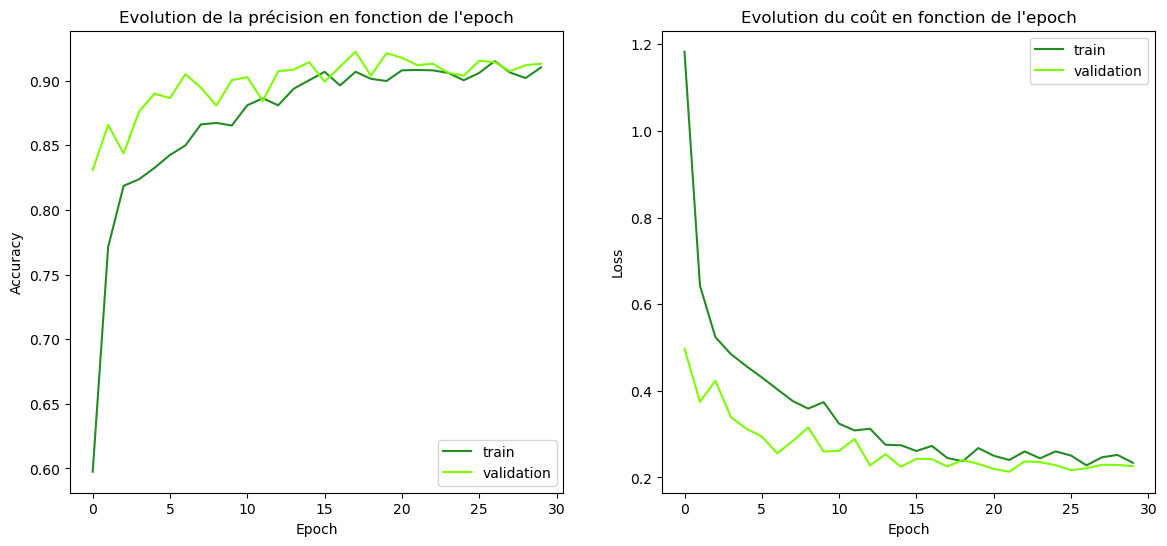

In [62]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement

def plot_history():
    training_history = pd.read_csv(csvlogger_filepath,index_col = 'epoch')
    fig, ax = plt.subplots(1, 2, figsize=(14,6))
    ax[0].plot(training_history['accuracy'], color='forestgreen')
    ax[0].plot(training_history['val_accuracy'], color='lawngreen')
    ax[0].set_title("Evolution de la précision en fonction de l'epoch")
    ax[0].set_xlabel("Epoch")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(['train', 'validation'], loc='best');
    ax[1].plot(training_history['loss'], color='forestgreen')
    ax[1].plot(training_history['val_loss'], color='lawngreen')
    ax[1].set_title("Evolution du coût en fonction de l'epoch")
    ax[1].set_xlabel("Epoch")
    ax[1].set_ylabel("Loss")
    ax[1].legend(['train', 'validation'], loc='best');
    
plot_history()

#### Etape 2: Fine-tuning du modèle par de-freezes successifs du modèle de base et ajustement du learning rate

##### Etape 2.1: De-freeze des 2 derniers blocs (15 et 16) du modèle de base

In [25]:
# Identification des couches à de-freezer
for i,layer in enumerate(base_model.layers):
    print(i,layer.name,"Trainable:",layer.trainable)


0 input_1 Trainable: False
1 Conv1 Trainable: False
2 bn_Conv1 Trainable: False
3 Conv1_relu Trainable: False
4 expanded_conv_depthwise Trainable: False
5 expanded_conv_depthwise_BN Trainable: False
6 expanded_conv_depthwise_relu Trainable: False
7 expanded_conv_project Trainable: False
8 expanded_conv_project_BN Trainable: False
9 block_1_expand Trainable: False
10 block_1_expand_BN Trainable: False
11 block_1_expand_relu Trainable: False
12 block_1_pad Trainable: False
13 block_1_depthwise Trainable: False
14 block_1_depthwise_BN Trainable: False
15 block_1_depthwise_relu Trainable: False
16 block_1_project Trainable: False
17 block_1_project_BN Trainable: False
18 block_2_expand Trainable: False
19 block_2_expand_BN Trainable: False
20 block_2_expand_relu Trainable: False
21 block_2_depthwise Trainable: False
22 block_2_depthwise_BN Trainable: False
23 block_2_depthwise_relu Trainable: False
24 block_2_project Trainable: False
25 block_2_project_BN Trainable: False
26 block_2_add Tr

In [27]:
for layer in base_model.layers[134:]:
    layer.trainable = True

In [29]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('UnFreeze_1','best_weights.ckpt')
csvlogger_filepath = Path('UnFreeze_1','training_history.csv')
loadweights_filepath = Path('Freeze','best_weights.ckpt')
lr=1.e-4
nb_epochs=40

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Epoch 1/40
110/110 [==============================] - ETA: 0s - loss: 0.5487 - accuracy: 0.8135
Epoch 1: val_accuracy improved from -inf to 0.78704, saving model to Models_training\MobileNetV2_ThresholdSegmentation\UnFreeze_1\best_weights.ckpt
110/110 [==============================] - 169s 2s/step - loss: 0.5487 - accuracy: 0.8135 - val_loss: 0.6688 - val_accuracy: 0.7870 - lr: 1.2500e-04
Epoch 2/40
110/110 [==============================] - ETA: 0s - loss: 0.3461 - accuracy: 0.8719
Epoch 2: val_accuracy improved from 0.78704 to 0.83218, saving model to Models_training\MobileNetV2_ThresholdSegmentation\UnFreeze_1\best_weights.ckpt
110/110 [==============================] - 108s 984ms/step - loss: 0.3461 - accuracy: 0.8719 - val_loss: 0.5313 - val_accuracy: 0.8322 - lr: 1.2500e-04
Epoch 3/40
110/110 [==============================] - ETA: 0s - loss: 0.3008 - accuracy: 0.8930
Epoch 3: val_accuracy improved from 0.83218 to 0.88079, saving model to Models_training\MobileNetV2_ThresholdSeg

110/110 [==============================] - 102s 932ms/step - loss: 0.1355 - accuracy: 0.9471 - val_loss: 0.1720 - val_accuracy: 0.9340 - lr: 7.8125e-06
Epoch 24/40
110/110 [==============================] - ETA: 0s - loss: 0.1256 - accuracy: 0.9536
Epoch 24: val_accuracy did not improve from 0.94097
110/110 [==============================] - 103s 938ms/step - loss: 0.1256 - accuracy: 0.9536 - val_loss: 0.1620 - val_accuracy: 0.9398 - lr: 7.8125e-06
Epoch 25/40
110/110 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.9456
Epoch 25: ReduceLROnPlateau reducing learning rate to 3.906250185536919e-06.

Epoch 25: val_accuracy did not improve from 0.94097
110/110 [==============================] - 103s 938ms/step - loss: 0.1363 - accuracy: 0.9456 - val_loss: 0.1556 - val_accuracy: 0.9410 - lr: 7.8125e-06
Epoch 26/40
110/110 [==============================] - ETA: 0s - loss: 0.1261 - accuracy: 0.9525
Epoch 26: val_accuracy did not improve from 0.94097
110/110 [==========

In [30]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 71.0 minutes.


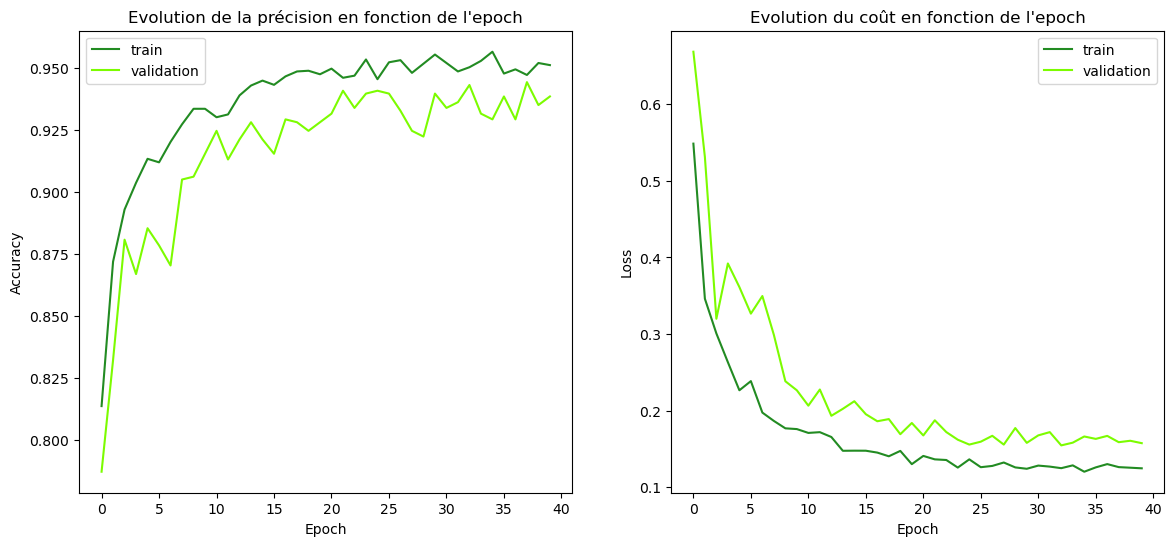

In [64]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

##### Etape 2.2: De-freeze des blocs 13 et 14 du modèle de base

In [33]:
for layer in base_model.layers[116:]:
    layer.trainable = True

In [35]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('UnFreeze_2','best_weights.ckpt')
csvlogger_filepath = Path('UnFreeze_2','training_history.csv')
loadweights_filepath = Path('UnFreeze_1','best_weights.ckpt')
lr=1.e-4
nb_epochs=35

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Epoch 1/35
110/110 [==============================] - ETA: 0s - loss: 0.2259 - accuracy: 0.9189
Epoch 1: val_accuracy improved from -inf to 0.89352, saving model to Models_training\MobileNetV2_ThresholdSegmentation\UnFreeze_2\best_weights.ckpt
110/110 [==============================] - 155s 1s/step - loss: 0.2259 - accuracy: 0.9189 - val_loss: 0.2879 - val_accuracy: 0.8935 - lr: 1.0000e-04
Epoch 2/35
110/110 [==============================] - ETA: 0s - loss: 0.2032 - accuracy: 0.9260
Epoch 2: val_accuracy did not improve from 0.89352
110/110 [==============================] - 116s 1s/step - loss: 0.2032 - accuracy: 0.9260 - val_loss: 0.3883 - val_accuracy: 0.8715 - lr: 1.0000e-04
Epoch 3/35
110/110 [==============================] - ETA: 0s - loss: 0.1719 - accuracy: 0.9351
Epoch 3: val_accuracy did not improve from 0.89352
110/110 [==============================] - 118s 1s/step - loss: 0.1719 - accuracy: 0.9351 - val_loss: 0.3746 - val_accuracy: 0.8704 - lr: 1.0000e-04
Epoch 4/35
110/

In [36]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 65.0 minutes.


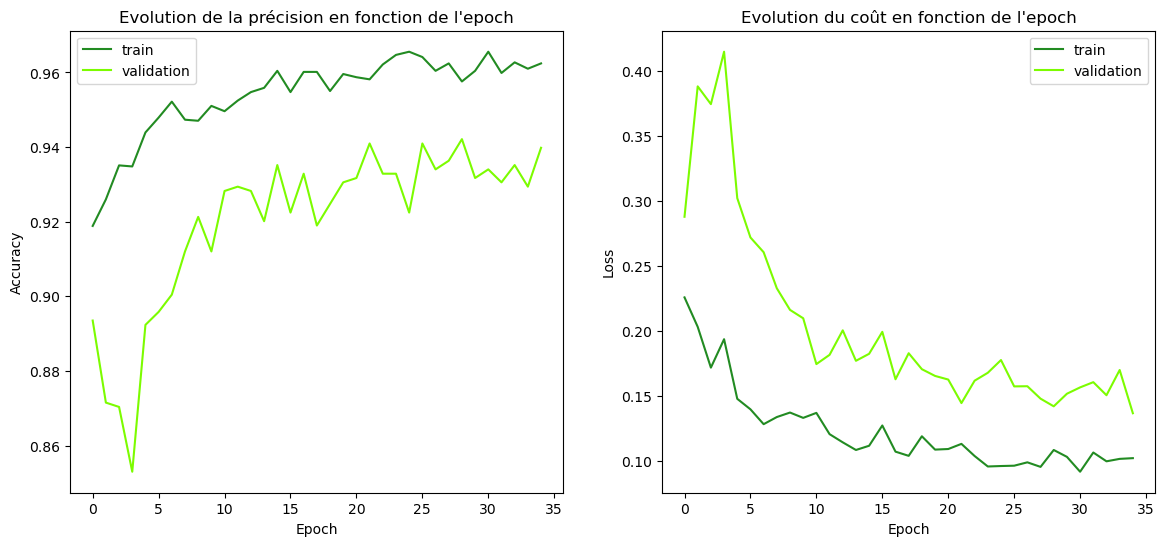

In [66]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

##### Etape 2.3: De-freeze des blocs 11 et 12 du modèle de base

In [39]:
for layer in base_model.layers[98:]:
    layer.trainable = True

In [46]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('UnFreeze_3','best_weights.ckpt')
csvlogger_filepath = Path('UnFreeze_3','training_history.csv')
loadweights_filepath = Path('UnFreeze_2','best_weights.ckpt')
lr=1.e-4
nb_epochs=35

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Epoch 1/35
110/110 [==============================] - ETA: 0s - loss: 0.1905 - accuracy: 0.9277
Epoch 1: val_accuracy improved from -inf to 0.91782, saving model to Models_training\MobileNetV2_ThresholdSegmentation\UnFreeze_3\best_weights.ckpt
110/110 [==============================] - 142s 1s/step - loss: 0.1905 - accuracy: 0.9277 - val_loss: 0.2002 - val_accuracy: 0.9178 - lr: 1.0000e-04
Epoch 2/35
110/110 [==============================] - ETA: 0s - loss: 0.1875 - accuracy: 0.9320
Epoch 2: val_accuracy did not improve from 0.91782
110/110 [==============================] - 141s 1s/step - loss: 0.1875 - accuracy: 0.9320 - val_loss: 0.2608 - val_accuracy: 0.9051 - lr: 1.0000e-04
Epoch 3/35
110/110 [==============================] - ETA: 0s - loss: 0.1586 - accuracy: 0.9414
Epoch 3: val_accuracy did not improve from 0.91782
110/110 [==============================] - 141s 1s/step - loss: 0.1586 - accuracy: 0.9414 - val_loss: 0.2033 - val_accuracy: 0.9178 - lr: 1.0000e-04
Epoch 4/35
110/

In [47]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 79.0 minutes.


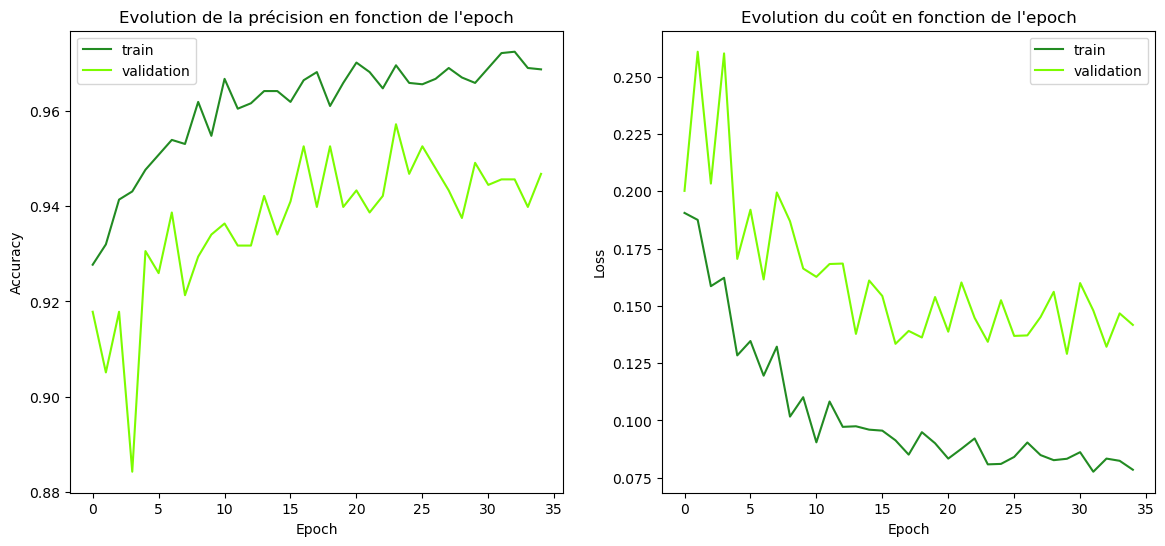

In [68]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

##### Etape 2.4: De-freeze des blocs 9 et 10 du modèle de base

In [53]:
for layer in base_model.layers[81:]:
    layer.trainable = True

In [55]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('UnFreeze_4','best_weights.ckpt')
csvlogger_filepath = Path('UnFreeze_4','training_history.csv')
loadweights_filepath = Path('UnFreeze_3','best_weights.ckpt')
lr=1.e-4
nb_epochs=35

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Epoch 1/35
110/110 [==============================] - ETA: 0s - loss: 0.1571 - accuracy: 0.9419
Epoch 1: val_accuracy improved from -inf to 0.93056, saving model to Models_training\MobileNetV2_ThresholdSegmentation\UnFreeze_4\best_weights.ckpt
110/110 [==============================] - 205s 2s/step - loss: 0.1571 - accuracy: 0.9419 - val_loss: 0.1891 - val_accuracy: 0.9306 - lr: 1.0000e-04
Epoch 2/35
110/110 [==============================] - ETA: 0s - loss: 0.1404 - accuracy: 0.9502
Epoch 2: val_accuracy did not improve from 0.93056
110/110 [==============================] - 171s 2s/step - loss: 0.1404 - accuracy: 0.9502 - val_loss: 0.1990 - val_accuracy: 0.9213 - lr: 1.0000e-04
Epoch 3/35
110/110 [==============================] - ETA: 0s - loss: 0.1368 - accuracy: 0.9502
Epoch 3: val_accuracy did not improve from 0.93056
110/110 [==============================] - 167s 2s/step - loss: 0.1368 - accuracy: 0.9502 - val_loss: 0.2577 - val_accuracy: 0.9155 - lr: 1.0000e-04
Epoch 4/35
110/

Epoch 25/35
110/110 [==============================] - ETA: 0s - loss: 0.0621 - accuracy: 0.9769
Epoch 25: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 25: val_accuracy did not improve from 0.95833
110/110 [==============================] - 150s 1s/step - loss: 0.0621 - accuracy: 0.9769 - val_loss: 0.1205 - val_accuracy: 0.9572 - lr: 1.5625e-06
Epoch 26/35
110/110 [==============================] - ETA: 0s - loss: 0.0570 - accuracy: 0.9804
Epoch 26: val_accuracy did not improve from 0.95833
110/110 [==============================] - 151s 1s/step - loss: 0.0570 - accuracy: 0.9804 - val_loss: 0.1248 - val_accuracy: 0.9572 - lr: 7.8125e-07
Epoch 27/35
110/110 [==============================] - ETA: 0s - loss: 0.0657 - accuracy: 0.9755
Epoch 27: val_accuracy did not improve from 0.95833
110/110 [==============================] - 154s 1s/step - loss: 0.0657 - accuracy: 0.9755 - val_loss: 0.1221 - val_accuracy: 0.9537 - lr: 7.8125e-07
Epoch 28/35
110/110 [========

In [56]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 94.0 minutes.


In [69]:
csvlogger_filepath = Path('UnFreeze_4','training_history.csv')


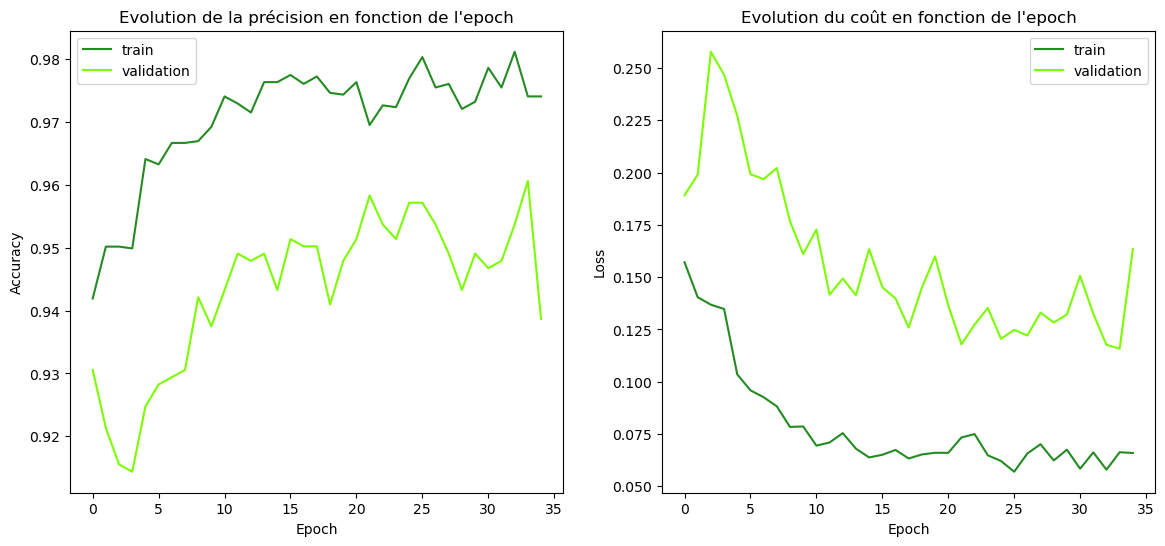

In [70]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

##### Etape 2.5: De-freeze des blocs 7 et 8 du modèle de base

In [59]:
for layer in base_model.layers[63:]:
    layer.trainable = True

In [61]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('UnFreeze_5','best_weights.ckpt')
csvlogger_filepath = Path('UnFreeze_5','training_history.csv')
loadweights_filepath = Path('UnFreeze_4','best_weights.ckpt')
lr=1.e-4
nb_epochs=35

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Epoch 1/35
110/110 [==============================] - ETA: 0s - loss: 0.1283 - accuracy: 0.9570
Epoch 1: val_accuracy improved from -inf to 0.95486, saving model to Models_training\MobileNetV2_ThresholdSegmentation\UnFreeze_5\best_weights.ckpt
110/110 [==============================] - 188s 2s/step - loss: 0.1283 - accuracy: 0.9570 - val_loss: 0.1278 - val_accuracy: 0.9549 - lr: 1.0000e-04
Epoch 2/35
110/110 [==============================] - ETA: 0s - loss: 0.1365 - accuracy: 0.9519
Epoch 2: val_accuracy did not improve from 0.95486
110/110 [==============================] - 187s 2s/step - loss: 0.1365 - accuracy: 0.9519 - val_loss: 0.2344 - val_accuracy: 0.9201 - lr: 1.0000e-04
Epoch 3/35
110/110 [==============================] - ETA: 0s - loss: 0.1297 - accuracy: 0.9527
Epoch 3: val_accuracy did not improve from 0.95486
110/110 [==============================] - 197s 2s/step - loss: 0.1297 - accuracy: 0.9527 - val_loss: 0.1622 - val_accuracy: 0.9352 - lr: 1.0000e-04
Epoch 4/35
110/

Epoch 26/35
110/110 [==============================] - ETA: 0s - loss: 0.0470 - accuracy: 0.9824
Epoch 26: val_accuracy improved from 0.96065 to 0.96181, saving model to Models_training\MobileNetV2_ThresholdSegmentation\UnFreeze_5\best_weights.ckpt
110/110 [==============================] - 197s 2s/step - loss: 0.0470 - accuracy: 0.9824 - val_loss: 0.1271 - val_accuracy: 0.9618 - lr: 3.9062e-07
Epoch 27/35
110/110 [==============================] - ETA: 0s - loss: 0.0486 - accuracy: 0.9792
Epoch 27: val_accuracy did not improve from 0.96181
110/110 [==============================] - 200s 2s/step - loss: 0.0486 - accuracy: 0.9792 - val_loss: 0.1301 - val_accuracy: 0.9537 - lr: 3.9062e-07
Epoch 28/35
110/110 [==============================] - ETA: 0s - loss: 0.0529 - accuracy: 0.9781
Epoch 28: ReduceLROnPlateau reducing learning rate to 1.9531249506599124e-07.

Epoch 28: val_accuracy did not improve from 0.96181
110/110 [==============================] - 193s 2s/step - loss: 0.0529 - acc

In [62]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 108.0 minutes.


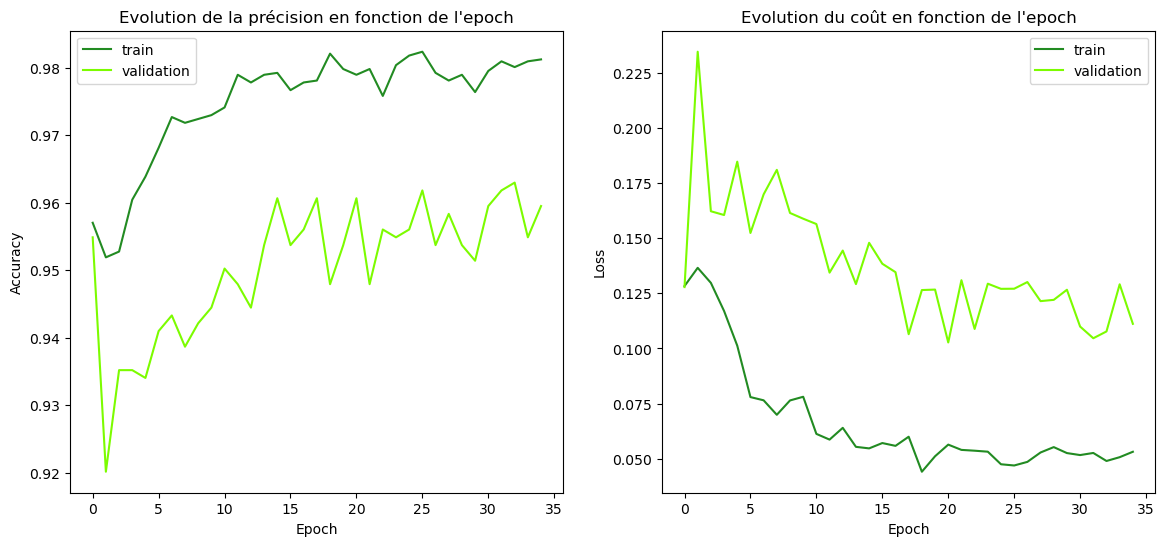

In [72]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

##### Etape 2.6: De-freeze des blocs 5 et 6 du modèle de base

In [65]:
for layer in base_model.layers[45:]:
    layer.trainable = True

In [67]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('UnFreeze_6','best_weights.ckpt')
csvlogger_filepath = Path('UnFreeze_6','training_history.csv')
loadweights_filepath = Path('UnFreeze_5','best_weights.ckpt')
lr=1.e-4
nb_epochs=35

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Epoch 1/35
110/110 [==============================] - ETA: 0s - loss: 0.1260 - accuracy: 0.9573
Epoch 1: val_accuracy improved from -inf to 0.92361, saving model to Models_training\MobileNetV2_ThresholdSegmentation\UnFreeze_6\best_weights.ckpt
110/110 [==============================] - 203s 2s/step - loss: 0.1260 - accuracy: 0.9573 - val_loss: 0.2166 - val_accuracy: 0.9236 - lr: 1.0000e-04
Epoch 2/35
110/110 [==============================] - ETA: 0s - loss: 0.1185 - accuracy: 0.9573
Epoch 2: val_accuracy improved from 0.92361 to 0.94097, saving model to Models_training\MobileNetV2_ThresholdSegmentation\UnFreeze_6\best_weights.ckpt
110/110 [==============================] - 237s 2s/step - loss: 0.1185 - accuracy: 0.9573 - val_loss: 0.2002 - val_accuracy: 0.9410 - lr: 1.0000e-04
Epoch 3/35
110/110 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.9587
Epoch 3: val_accuracy did not improve from 0.94097
110/110 [==============================] - 236s 2s/step - loss: 

Epoch 25/35
110/110 [==============================] - ETA: 0s - loss: 0.0397 - accuracy: 0.9886
Epoch 25: val_accuracy did not improve from 0.96875
110/110 [==============================] - 201s 2s/step - loss: 0.0397 - accuracy: 0.9886 - val_loss: 0.1124 - val_accuracy: 0.9676 - lr: 1.5625e-06
Epoch 26/35
110/110 [==============================] - ETA: 0s - loss: 0.0360 - accuracy: 0.9866
Epoch 26: val_accuracy did not improve from 0.96875
110/110 [==============================] - 205s 2s/step - loss: 0.0360 - accuracy: 0.9866 - val_loss: 0.1005 - val_accuracy: 0.9664 - lr: 1.5625e-06
Epoch 27/35
110/110 [==============================] - ETA: 0s - loss: 0.0393 - accuracy: 0.9852
Epoch 27: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 27: val_accuracy improved from 0.96875 to 0.97106, saving model to Models_training\MobileNetV2_ThresholdSegmentation\UnFreeze_6\best_weights.ckpt
110/110 [==============================] - 198s 2s/step - loss: 0.0393 - accur

In [68]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 119.0 minutes.


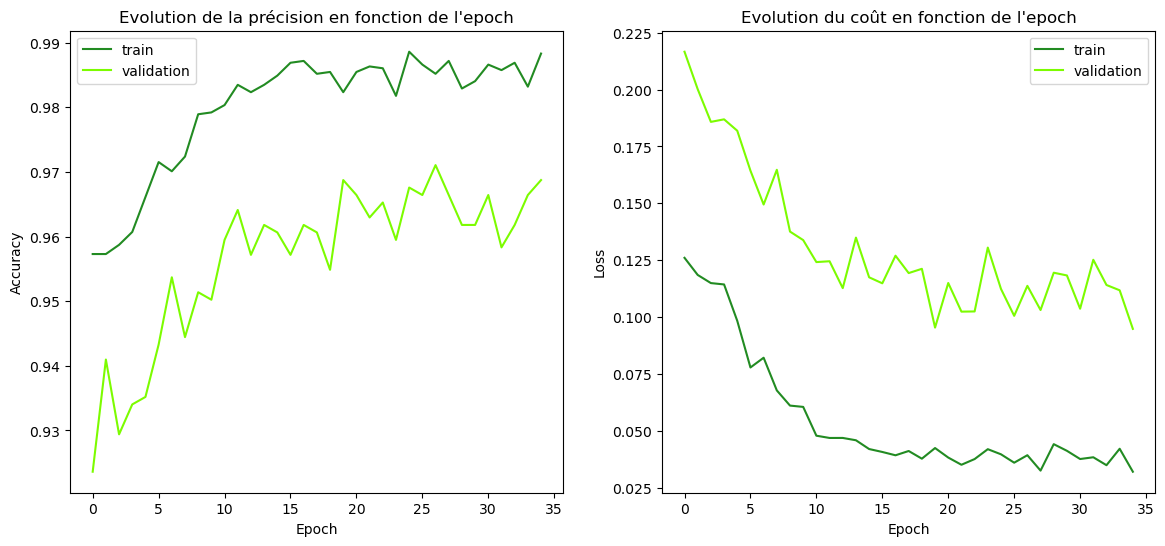

In [74]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

##### Etape 2.7: De-freeze des blocs 3 et 4 du modèle de base

In [71]:
for layer in base_model.layers[27:]:
    layer.trainable = True

In [82]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('UnFreeze_7','best_weights.ckpt')
csvlogger_filepath = Path('UnFreeze_7','training_history.csv')
loadweights_filepath = Path('UnFreeze_6','best_weights.ckpt')
lr=1.e-4
nb_epochs=35

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Epoch 1/35
110/110 [==============================] - ETA: 0s - loss: 0.1169 - accuracy: 0.9610
Epoch 1: val_accuracy improved from -inf to 0.92593, saving model to Models_training\MobileNetV2_ThresholdSegmentation\UnFreeze_7\best_weights.ckpt
110/110 [==============================] - 259s 2s/step - loss: 0.1169 - accuracy: 0.9610 - val_loss: 0.2808 - val_accuracy: 0.9259 - lr: 1.0000e-04
Epoch 2/35
110/110 [==============================] - ETA: 0s - loss: 0.0922 - accuracy: 0.9661
Epoch 2: val_accuracy improved from 0.92593 to 0.92824, saving model to Models_training\MobileNetV2_ThresholdSegmentation\UnFreeze_7\best_weights.ckpt
110/110 [==============================] - 259s 2s/step - loss: 0.0922 - accuracy: 0.9661 - val_loss: 0.2348 - val_accuracy: 0.9282 - lr: 1.0000e-04
Epoch 3/35
110/110 [==============================] - ETA: 0s - loss: 0.1101 - accuracy: 0.9621
Epoch 3: val_accuracy did not improve from 0.92824
110/110 [==============================] - 265s 2s/step - loss: 

Epoch 25/35
110/110 [==============================] - ETA: 0s - loss: 0.0356 - accuracy: 0.9852
Epoch 25: val_accuracy improved from 0.95949 to 0.96412, saving model to Models_training\MobileNetV2_ThresholdSegmentation\UnFreeze_7\best_weights.ckpt
110/110 [==============================] - 239s 2s/step - loss: 0.0356 - accuracy: 0.9852 - val_loss: 0.1251 - val_accuracy: 0.9641 - lr: 1.5625e-06
Epoch 26/35
110/110 [==============================] - ETA: 0s - loss: 0.0351 - accuracy: 0.9872
Epoch 26: val_accuracy did not improve from 0.96412
110/110 [==============================] - 256s 2s/step - loss: 0.0351 - accuracy: 0.9872 - val_loss: 0.1171 - val_accuracy: 0.9630 - lr: 1.5625e-06
Epoch 27/35
110/110 [==============================] - ETA: 0s - loss: 0.0313 - accuracy: 0.9906
Epoch 27: val_accuracy did not improve from 0.96412
110/110 [==============================] - 212s 2s/step - loss: 0.0313 - accuracy: 0.9906 - val_loss: 0.1284 - val_accuracy: 0.9583 - lr: 1.5625e-06
Epoch 

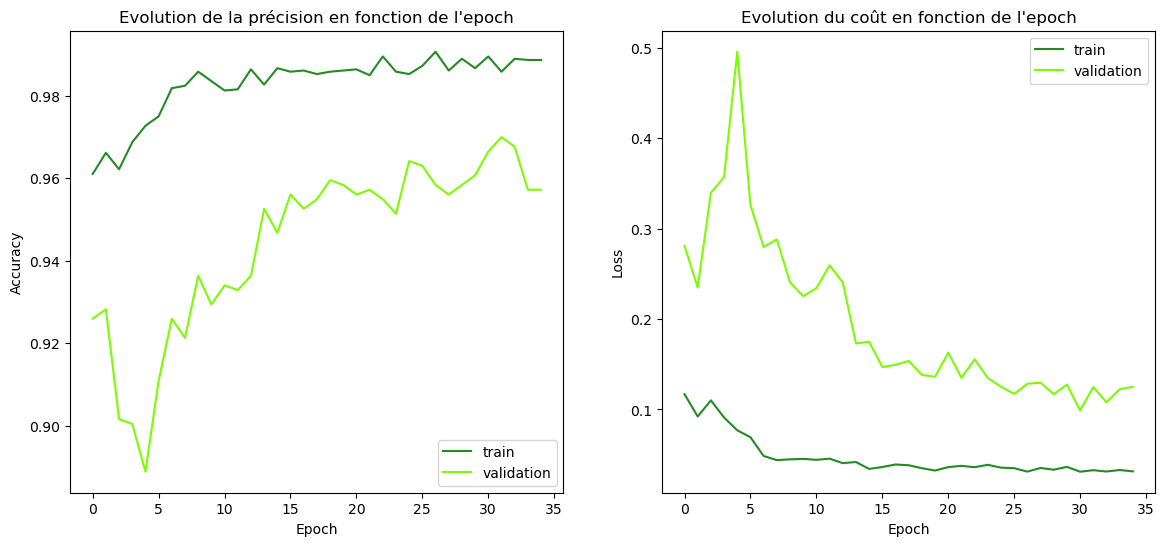

In [76]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

##### Etape 2.8: De-freeze des blocs 1 et 2 du modèle de base

In [45]:
for layer in base_model.layers[9:]:
    layer.trainable = True

In [47]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('UnFreeze_8','best_weights.ckpt')
csvlogger_filepath = Path('UnFreeze_8','training_history.csv')
loadweights_filepath = Path('UnFreeze_7','best_weights.ckpt')
lr=1.e-4
nb_epochs=35

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Epoch 1/35
110/110 [==============================] - ETA: 0s - loss: 0.0957 - accuracy: 0.9647
Epoch 1: val_accuracy improved from -inf to 0.94213, saving model to Models_training\MobileNetV2_ThresholdSegmentation\UnFreeze_8\best_weights.ckpt
110/110 [==============================] - 327s 3s/step - loss: 0.0957 - accuracy: 0.9647 - val_loss: 0.1565 - val_accuracy: 0.9421 - lr: 1.0000e-04
Epoch 2/35
110/110 [==============================] - ETA: 0s - loss: 0.0951 - accuracy: 0.9675
Epoch 2: val_accuracy did not improve from 0.94213
110/110 [==============================] - 297s 3s/step - loss: 0.0951 - accuracy: 0.9675 - val_loss: 0.3048 - val_accuracy: 0.8981 - lr: 1.0000e-04
Epoch 3/35
110/110 [==============================] - ETA: 0s - loss: 0.0883 - accuracy: 0.9678
Epoch 3: val_accuracy did not improve from 0.94213
110/110 [==============================] - 307s 3s/step - loss: 0.0883 - accuracy: 0.9678 - val_loss: 0.3662 - val_accuracy: 0.8854 - lr: 1.0000e-04
Epoch 4/35
110/

Epoch 24/35
110/110 [==============================] - ETA: 0s - loss: 0.0346 - accuracy: 0.9872
Epoch 24: val_accuracy did not improve from 0.97106
110/110 [==============================] - 271s 2s/step - loss: 0.0346 - accuracy: 0.9872 - val_loss: 0.1304 - val_accuracy: 0.9595 - lr: 1.5625e-06
Epoch 25/35
110/110 [==============================] - ETA: 0s - loss: 0.0293 - accuracy: 0.9898
Epoch 25: ReduceLROnPlateau reducing learning rate to 7.81249980263965e-07.

Epoch 25: val_accuracy did not improve from 0.97106
110/110 [==============================] - 271s 2s/step - loss: 0.0293 - accuracy: 0.9898 - val_loss: 0.1188 - val_accuracy: 0.9572 - lr: 1.5625e-06
Epoch 26/35
110/110 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.9883
Epoch 26: val_accuracy did not improve from 0.97106
110/110 [==============================] - 260s 2s/step - loss: 0.0308 - accuracy: 0.9883 - val_loss: 0.1406 - val_accuracy: 0.9595 - lr: 7.8125e-07
Epoch 27/35
110/110 [========

In [48]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 159.0 minutes.


In [77]:
csvlogger_filepath = Path('UnFreeze_8','training_history.csv')


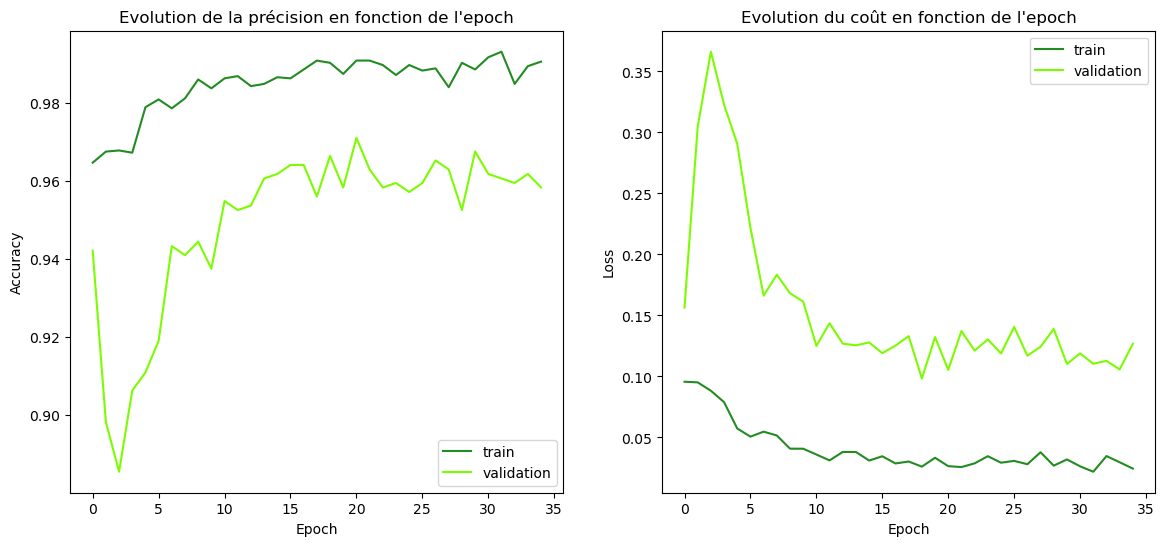

In [78]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

##### Etape 2.9: De-freeze complet du modèle de base

In [95]:
for layer in base_model.layers:
    layer.trainable = True

In [103]:
# Définition des paramètres d'entraînement
checkpoint_filepath = Path('UnFreeze_9','best_weights.ckpt')
csvlogger_filepath = Path('UnFreeze_9','training_history.csv')
loadweights_filepath = Path('UnFreeze_8','best_weights.ckpt')
lr=1.e-4
nb_epochs=60

# Lancement de l'entraînement
model_load_and_fit(checkpoint_filepath,csvlogger_filepath,loadweights_filepath=loadweights_filepath,lr=lr,nb_epochs=nb_epochs)

Epoch 1/60
110/110 [==============================] - ETA: 0s - loss: 0.0876 - accuracy: 0.9701
Epoch 1: val_accuracy improved from -inf to 0.95139, saving model to Models_training\MobileNetV2_ThresholdSegmentation\UnFreeze_9\best_weights.ckpt
110/110 [==============================] - 445s 4s/step - loss: 0.0876 - accuracy: 0.9701 - val_loss: 0.1859 - val_accuracy: 0.9514 - lr: 1.0000e-04
Epoch 2/60
110/110 [==============================] - ETA: 0s - loss: 0.0636 - accuracy: 0.9784
Epoch 2: val_accuracy did not improve from 0.95139
110/110 [==============================] - 432s 4s/step - loss: 0.0636 - accuracy: 0.9784 - val_loss: 0.2178 - val_accuracy: 0.9410 - lr: 1.0000e-04
Epoch 3/60
110/110 [==============================] - ETA: 0s - loss: 0.0848 - accuracy: 0.9724
Epoch 3: val_accuracy did not improve from 0.95139
110/110 [==============================] - 402s 4s/step - loss: 0.0848 - accuracy: 0.9724 - val_loss: 0.4107 - val_accuracy: 0.8970 - lr: 1.0000e-04
Epoch 4/60
110/

110/110 [==============================] - 373s 3s/step - loss: 0.0257 - accuracy: 0.9917 - val_loss: 0.1745 - val_accuracy: 0.9491 - lr: 7.8125e-07
Epoch 26/60
110/110 [==============================] - ETA: 0s - loss: 0.0268 - accuracy: 0.9903
Epoch 26: val_accuracy improved from 0.95718 to 0.95949, saving model to Models_training\MobileNetV2_ThresholdSegmentation\UnFreeze_9\best_weights.ckpt
110/110 [==============================] - 362s 3s/step - loss: 0.0268 - accuracy: 0.9903 - val_loss: 0.1740 - val_accuracy: 0.9595 - lr: 3.9062e-07
Epoch 27/60
110/110 [==============================] - ETA: 0s - loss: 0.0234 - accuracy: 0.9926
Epoch 27: val_accuracy improved from 0.95949 to 0.96181, saving model to Models_training\MobileNetV2_ThresholdSegmentation\UnFreeze_9\best_weights.ckpt
110/110 [==============================] - 375s 3s/step - loss: 0.0234 - accuracy: 0.9926 - val_loss: 0.1448 - val_accuracy: 0.9618 - lr: 3.9062e-07
Epoch 28/60
110/110 [==============================] - 

Epoch 50/60
110/110 [==============================] - ETA: 0s - loss: 0.0302 - accuracy: 0.9883
Epoch 50: val_accuracy did not improve from 0.96875
110/110 [==============================] - 387s 4s/step - loss: 0.0302 - accuracy: 0.9883 - val_loss: 0.1394 - val_accuracy: 0.9606 - lr: 3.0518e-09
Epoch 51/60
110/110 [==============================] - ETA: 0s - loss: 0.0265 - accuracy: 0.9912
Epoch 51: ReduceLROnPlateau reducing learning rate to 1.5258788677030566e-09.

Epoch 51: val_accuracy did not improve from 0.96875
110/110 [==============================] - 368s 3s/step - loss: 0.0265 - accuracy: 0.9912 - val_loss: 0.1177 - val_accuracy: 0.9664 - lr: 3.0518e-09
Epoch 52/60
110/110 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9926
Epoch 52: val_accuracy did not improve from 0.96875
110/110 [==============================] - 366s 3s/step - loss: 0.0208 - accuracy: 0.9926 - val_loss: 0.1117 - val_accuracy: 0.9688 - lr: 1.5259e-09
Epoch 53/60
110/110 [======

In [104]:
print("Durée de l'entraînement:",time_callback.logs[-1]//60,"minutes.")

Durée de l'entraînement: 380.0 minutes.


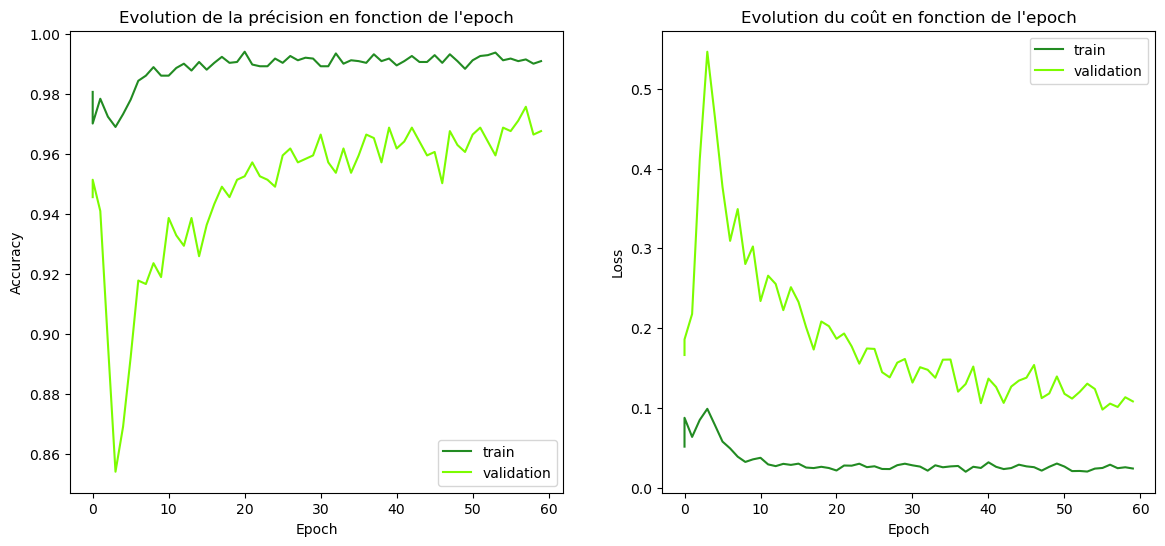

In [80]:
# Visualisation de la convergence de la fonction de perte et de l'accuracy au long de l'entraînement
plot_history()

#### Sauvegarde du modèle final (intégralement de-freezé et entraîné) avec les meilleurs poids

In [99]:
# Chargement des meilleurs poids
model.load_weights(Path('UnFreeze_9','best_weights.ckpt'))

In [104]:
# Sauvegarde au format TensorFlow SavedModel
saving_filepath = Path('Final_model')
model.save(saving_filepath)

INFO:tensorflow:Assets written to: mobilenetV2_lowaugm_segmentation\Final_model\assets


INFO:tensorflow:Assets written to: mobilenetV2_lowaugm_segmentation\Final_model\assets


### Evaluation du modèle

In [105]:
# Chargement du modèle final
model = load_model(saving_filepath)

In [102]:
# Evaluation sur les jeux train, validation et test
res = pd.DataFrame(index=['train','validation','test'],columns=['loss','accuracy'])
res.iloc[0,:] = model.evaluate(train_iterator)
res.iloc[1,:] = model.evaluate(validation_iterator)
res.iloc[2,:] = model.evaluate(test_iterator)

# Sauvegarde dans un fichier CSV
res.to_csv('mobilenetV2_unfreezed_lowaugm_segmentation_results.csv')

35/35 [==============================] - 18s 506ms/step - loss: 0.1661 - accuracy: 0.9666


In [103]:
# Affichage des résultats
res

,loss,accuracy
train,0.013525,0.995487
validation,0.103314,0.972912
test,0.166062,0.966606


35/35 [==============================] - 33s 857ms/step
                           precision    recall  f1-score   support

              Black-grass       0.84      0.76      0.80        62
                 Charlock       1.00      1.00      1.00        90
                 Cleavers       1.00      1.00      1.00        67
         Common Chickweed       0.99      0.98      0.99       143
             Common wheat       0.91      1.00      0.95        51
                  Fat Hen       0.98      0.98      0.98       108
         Loose Silky-bent       0.91      0.94      0.92       152
                    Maize       1.00      0.98      0.99        51
        Scentless Mayweed       0.97      0.99      0.98       121
         Shepherd's Purse       0.98      0.95      0.96        55
Small-flowered Cranesbill       1.00      1.00      1.00       115
               Sugar beet       1.00      0.97      0.98        93

                 accuracy                           0.97      1108
    

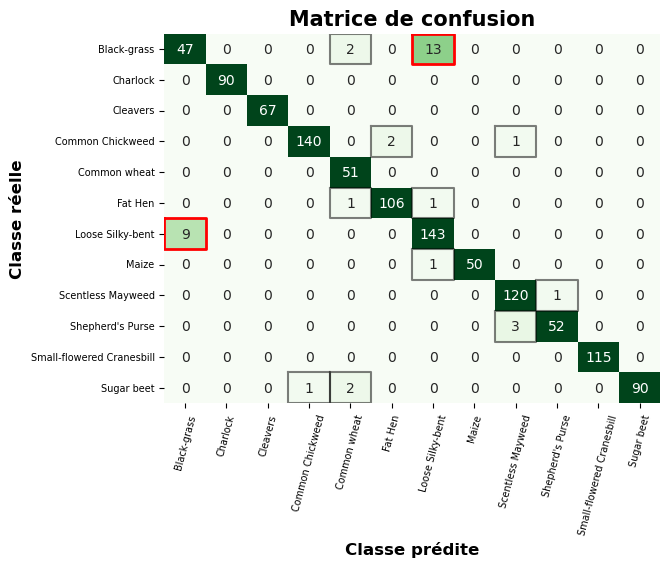

In [20]:
# Rapport de classification & matrice de confusion

def show_metrics():
    y_true = test_iterator.classes
    y_pred = model.predict(test_iterator).argmax(axis=-1)

    print(classification_report(y_true, y_pred, target_names = test_iterator.class_indices.keys()))
    
    matrix = confusion_matrix(y_true, y_pred)
    classes = test_iterator.class_indices.keys()
    sns.heatmap(matrix, annot=True,cmap="Greens", fmt = 'd',vmin=0,vmax=30,cbar=False)
    tick_marks = np.arange(0.5, len(classes), 1)
    plt.xticks(tick_marks, classes, rotation=75, fontsize = 7)
    plt.yticks(tick_marks, classes, rotation=0, fontsize = 7)
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        if (i!=j) and (matrix[i,j] !=0):
            if (matrix[i,j] > matrix.mean()):
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="red", linewidth=2)
            else:
                plt.plot((j,j,j+1,j+1,j),(i,i+1,i+1,i, i), color="k", alpha = 0.5)
    plt.ylabel("Classe réelle", fontweight = 'bold', fontsize = 12)
    plt.xlabel("Classe prédite", fontweight = 'bold', fontsize = 12)
    plt.title("Matrice de confusion", fontweight = 'extra bold', fontsize = 15);

show_metrics()